# ADMM Optimizer
The latest version of this notebook is available on https://github.com/Qiskit/qiskit-iqx-tutorials.

- Explain what problems this optimizer can solve
- Introduce algorithm on high-level and refer to paper
- explain that it takes a qubo_optimizer and cts_optimizer 
- Link to other optimizers (QAOA, Grover, ...) 
- Show Example

## Introduction

The ADMM Optimizer can solve classes of mixed-binary constrained optimization problems, hereafter (MBCO), which often appear in logistic, finance, and operation research. In particular, the ADMM Optimizer here designed can tackle the following optimization problem $(P)$:

$$
\min_{x \in \mathcal{X},u\in\mathcal{U} \subseteq \mathbb{R}^l } \quad q(x) + \varphi(u),
$$

subject to the constraints:

$$
\mathrm{s.t.:~} \quad G x = b, \quad  g(x) \leq 0, \quad \ell(x, u) \leq 0, 
$$

with the corresponding functional assumptions.

1. Function $q: \mathbb{R}^n \to \mathbb{R}$ is quadratic, i.e., $q(x) = x^{\intercal} Q x + a^{\intercal} x$ for a given symmetric squared matrix $Q \in \mathbb{R}^n \times \mathbb{R}^n, Q = Q^{\intercal}$, and vector $a \in \mathbb{R}^n$;
2. The set $\mathcal{X} = \{0,1\}^n = \{x_{(i)} (1-x_{(i)}) = 0, \forall i\}$ enforces the binary constraints;
3. Matrix $G\in\mathbb{R}^n \times \mathbb{R}^{n'}$, vector $b \in \mathbb{R}^{n'}$, and function $g: \mathbb{R}^n \to \mathbb{R}$ is convex;
4. Function $\varphi: \mathbb{R}^l \to \mathbb{R}$ is convex and $\mathcal{U}$ is a convex set;
5. Function $\ell: \mathbb{R}^n\times  \mathbb{R}^l \to \mathbb{R}$ is *jointly* convex in $x, u$.

In order to solve MBO problems, [1] proposed heuristics for $(P)$ based on the Alternating Direction Method of Multipliers (ADMM) [2]. ADMM is an operator splitting algorithm with a long history in convex optimization, and it is known to have residual, objective and dual variable convergence properties, provided that convexity assumptions are holding.

The method of [1] (referred to as 3-ADMM-H) leverages the ADMM operator-splitting procedure to devise a decomposition for certain classes of MBOs into:
- a QUBO subproblem to be solved by on the quantum device via variational algorithms, such as VQE or QAOA;
- continuous convex constrained subproblem, which can be efficiently solved with classical optimization solvers.

The algorithm 3-ADMM-H works as follows:

0. Initialization phase (set the parameters and the QUBO and convex solvers);
1. For each ADMM iterations ($k = 1, 2, \ldots, $) till termination:
    - Solve a properly defined QUBO subproblem (with a classical or quantum solver);
    - Solve properly defined convex problems (with a classical solver);
    - Update the dual variables.
2. Return optimizers and cost.

    
A comprehensive discussion on the conditions for convergence, feasibility and optimality of the algorithm can be found in [1]. A variant with 2 ADMM blocks, namely a QUBO subproblem, and a continuous convex constrained subproblem, is also introduced in [1].

## References

[1] C. Gambella and A. Simonetto, *Multi-block ADMM  heuristics  for  mixed-binary  optimization, on  classical  and  quantum  computers,*  arXiv  preprint arXiv:2001.02069  (2020).

[2] S. Boyd, N. Parikh, E. Chu, B. Peleato, and J. Eckstein, *Distributed  optimization  and statistical learning via the alternating direction method of  multipliers,*  Foundations  and  Trends in  Machine learning, 3, 1–122 (2011).

## Initialization
First of all we load all the packages that we need:

* Python 3.6 or greater is required;
* CPLEX 12.10 or greater is required for the classical computations;
* Latest Qiskit is required for the quantum computations.

In [1]:
import logging
import time
from typing import List, Optional, Any

import numpy as np
from cplex import SparsePair
from qiskit.optimization.algorithms.cplex_optimizer import CplexOptimizer
from qiskit.optimization.algorithms.optimization_algorithm import OptimizationAlgorithm
from qiskit.optimization.problems.optimization_problem import OptimizationProblem
from qiskit.optimization.problems.variables import CPX_BINARY, CPX_CONTINUOUS
from qiskit.optimization.results.optimization_result import OptimizationResult

## Example - Classical Solution

We test 3-ADMM-H algorithm on a simple Mixed-Binary Quadratic Problem with equality and inequality constraints (Example 6 reported in [1]). We first load necessary packages and populate with docplex. 3-ADMM-H needs a QUBO optimizer to solve the QUBO subproblem, and a continuous optimizer to solve the continuous convex constrained subproblem. We first solve the problem classically: a minimum eigensolver optimizer is used as QUBO optimizers, while Cplex is the continuous convex solver. 3-ADMM-H supports any other suitable solver available in Qiskit. For instance, VQE, QAOA, and Grover can be invoked as quantum solvers.

In [2]:
from docplex.mp.model import Model

from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization import OptimizationProblem
from qiskit.optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer
from qiskit.optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer

elapsed_time = time.time()

mdl = Model('ex6')

v = mdl.binary_var(name='v')
w = mdl.binary_var(name='w')
t = mdl.binary_var(name='t')
u = mdl.continuous_var(name='u')

mdl.minimize(v + w + t + 5 * (u-2)**2)
mdl.add_constraint(v + 2 * w + t + u <= 3, "cons1")
mdl.add_constraint(v + w + t >= 1, "cons2")
mdl.add_constraint(v + w == 1, "cons3")


op = OptimizationProblem()
op.from_docplex(mdl)

qubo_optimizer = MinimumEigenOptimizer(NumPyMinimumEigensolver())
# qubo_optimizer = CplexOptimizer()

continuous_optimizer = CplexOptimizer()

### Parameters
The 3-ADMM-H are wrapped in class `ADMMParameters`. Customized parameter values can be set as arguments of the class. In this example, parameters $\rho, \beta$ are initialized to $1001$ and $1000$, respectively. The penalization `factor_c` of equality constraints $Gx = b$ is set to $900$. The tolerance `tol` for primal residual convergence is set to `1.e-6`. 
In this case, the 3-block implementation is guaranteed to converge for Theorem 4 of [1], because the inequality constraint with the continuous variable is always active. The 2-block implementation can be run by setting `three_block=False`, and practically converges to a feasible not optimal solution. 


In [3]:
admm_params = ADMMParameters(
                             rho_initial=1001, beta=1000, factor_c=900,
                             max_iter=100,  three_block=True, tol=1.e-6
                             )


### Calling 3-ADMM-H algorithm
To invoke the 3-ADMM-H algorithm, an instance of the `ADMMOptimizer` class needs to be created. This takes ADMM-specific parameters and the subproblem optimizers separately into the constructor. The solution returned is an instance of `OptimizationResult` class.

In [4]:
solver = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer,
                             continuous_optimizer=continuous_optimizer)
time_classical_sol = time.time()
solution = solver.solve(op)
time_classical_sol = time.time() - time_classical_sol

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 1 rows and 0 columns.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt   


Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 1 rows and 0 columns.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.01 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linea

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.00 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 1 rows and 0 columns.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve tim


Root node processing (before b&c):
  Real time             =    0.02 sec. (0.04 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.04 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Version identifier: 

Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0    -2110.6862    -2110.6862       12    0.00%
Elapsed time = 0.02 sec. (0.04 ticks, tree = 0.00 MB, solutions = 1)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.04 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.04 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

Root node

Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0    -3080.9723    -3080.9723       12    0.00%
Elapsed time = 0.02 sec. (0.04 ticks, tree = 0.00 MB, solutions = 1)

Root node processing (before b&c):
  Real time             =    0.03 sec. (0.04 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.03 sec. (0.04 ticks)
Version identifier: 12.10.0.0 | 201

Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0    -4501.5784    -4501.5784       12    0.00%
Elapsed time = 0.02 sec. (0.04 ticks, tree = 0.00 MB, solutions = 1)

Root node processin

  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
ADMM execution time - classical computation: 2.08s.


In [ ]:
print("ADMM execution time - classical computation: {:.2f}s.".format(time_classical_sol))

### Result
The 3-ADMM-H solution can be then printed and visualized. The `x` attribute of the solution contains respectively, the
values of the binary decision variables and the values of the continuous decision variables. The `fval` is the objective
value of the solution.

In [5]:
print("results")
print("x={}".format(solution.x))
print("fval={:.2f}".format(solution.fval))

results
x=[1.        0.        0.        1.9997753]
fval=1.00


Solution statistics can be accessed in the `state` field and visualized. We here display the convergence of 3-ADMM-H, in terms of primal residuals.

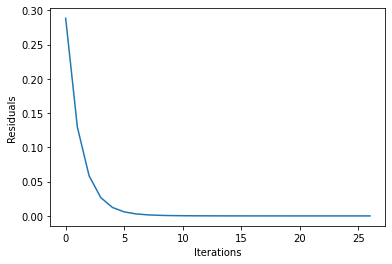

In [6]:
import matplotlib.pyplot as plt 
plt.clf()
plt.plot(solution.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

## Example - Quantum Solution
We now solve the same optimization problem with QAOA as QUBO optimizer, running on simulated quantum device. 
First, one need to select the classical optimizer of the eigensolver QAOA. Then, the simulation backened is set. Finally, 
the eigensolver is wrapped into the `MinimumEigenOptimizer` class. A new instance of `ADMMOptimizer` is populated with QAOA as QUBO optimizer.

In [7]:
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.algorithms import QAOA

optimizer = COBYLA()
min_eigen_solver = QAOA(optimizer=optimizer)
backend = 'statevector_simulator'
min_eigen_solver.quantum_instance = BasicAer.get_backend(backend)

# construct minimum eigen optimizer
min_eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver)
solver_q = ADMMOptimizer(params=admm_params, qubo_optimizer=min_eigen_optimizer,
                             continuous_optimizer=continuous_optimizer)

time_quantum_sol = time.time()
solution_q = solver_q.solve(op)
time_quantum_sol = time.time() - time_quantum_sol

print("results")
print("x={}".format(solution_q.x))
print("fval={:.2f}".format(solution_q.fval))



Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 1 rows and 0 columns.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt   


Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 1 rows and 0 columns.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linea

Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 1 rows and 0 columns.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve tim


Root node processing (before b&c):
  Real time             =    0.02 sec. (0.04 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.04 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Version identifier: 

Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0    -2110.6862    -2110.6862       12    0.00%
Elapsed time = 0.06 sec. (0.04 ticks, tree = 0.00 MB, solutions = 1)

Root node processing (before b&c):
  Real time             =    0.07 sec. (0.04 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.07 sec. (0.04 ticks)
Version identifier: 12.10.0.0 | 2019-11-27 | 843d4de
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 3 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

Root node

Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.01 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.01 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0    -3080.9723    -3080.9723       12    0.00%
Elapsed time = 0.03 sec. (0.04 ticks, tree = 0.00 MB, solutions = 1)

Root node processing (before b&c):
  Real time             =    0.03 sec. (0.04 ticks)
Parallel b&c, 12 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.03 sec. (0.04 ticks)
Version identifier: 12.10.0.0 | 201

Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.01 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 4 columns, and 7 nonzeros.
Reduced MIQP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 4 nonzeros.
Presolve time = 0.01 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.01 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0     0      integral     0    -4501.5784    -4501.5784       12    0.00%
Elapsed time = 0.05 sec. (0.04 ticks, tree = 0.00 MB, solutions = 1)

Root node processin

  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.00 ticks)
ADMM execution time - quantum computation: 13.20s.
results
x=[1.        0.        0.        1.9997753]
fval=1.00


In [ ]:
print("ADMM execution time - quantum computation: {:.2f}s.".format(time_quantum_sol))

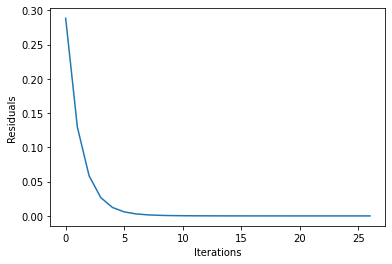

In [8]:
plt.clf()
plt.plot(solution_q.state.residuals)
plt.xlabel("Iterations")
plt.ylabel("Residuals")
plt.show()

In [9]:
elapsed_time = time.time() - elapsed_time
print("Total execution time: {:.2f}s".format(elapsed_time))

Total execution time: 15.79s
